In [23]:
"""
Alexandre
2024/10/18
"""

# Test the influence of differents parameters of the encoding layer. A) step duration in the input stimulation B) number of neurone int he encoding layer.

'\nAlexandre\n2024/10/18\n'

# **Initial tests**

## Initialisation part

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import nest
import os

In [25]:
cwd = os.getcwd()
print(cwd)

results_fodler_name = "B_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## network generation

In [26]:
# general parameters
gamma = 0.25 # relative number of inhibitory

# encoding layer parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA]

# main network parameters
NE = 1000 # number of excitatory neurons (10.000 in [1])
CE = 200 # indegree from excitatory neurons

# synapse parameters
w = 0.1 # excitatory synaptic weight (mV)
g = 5. # relative inhibitory to excitatory synaptic weight
d = 1.5 # synaptic transmission delay (ms)

In [27]:
def gen_network(
    gamma=gamma,
    # encoding layer parameters
    nEnc=nEnc,
    J_bias=J_bias,
    # main network parameters
    NE=NE,
    CE=CE, # indegree from excitatory neurons

    # synapse parameters
    w=w, # excitatory synaptic weight (mV)
    g=g, # relative inhibitory to excitatory synaptic weight
    d=d, # synaptic transmission delay (ms)
):
 
    # create the encoding layer
    enc_layer = nest.Create(
        model='iaf_psc_delta', 
        n=nEnc, 
        params={'I_e': J_bias}
    )

    # record the activity of the encoding layer
    enc_spks = nest.Create('spike_recorder')
    nest.Connect(enc_layer, enc_spks)

    ##### MAIN NETWORK #####
    # population parameters
    NI = int(gamma * NE) # number of inhibitory neurons
    CI = int(gamma * CE) # indegree from inhibitory neurons

    # neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }

    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    main_spks = nest.Create('spike_recorder')

    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, main_spks)

    # connect the encoding layer to both neuronal population
    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

    return enc_layer, enc_spks, main_spks

In [28]:
# set general parameters
seed = 1
dt = 0.1
num_threads = 16

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network()


Oct 23 17:40:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## generate input and connect it to the network

In [29]:
# import librairies input stimulus generator
from utils.inputs import generate_piecewise_constant_signal

In [30]:
# encoding layer parameters
nEnc = 500 # number of neurons in the encoding layer

# stimulus parameters
step_duration = 20. # [ms]
scale = 1. # input scaling factor [Hz]
num_steps = 500 # number of unique input values

In [31]:
def gen_input(
    # encoding layer parameters
    nEnc=nEnc,  # number of neurons in the encoding layer

    # stimulus parameters
    step_duration=step_duration, # [ms]
    scale=scale, # input scaling factor [Hz]
    num_steps=num_steps, # number of unique input values
):
    
    # encoding layer reparametrisation
    tuning = 250. * np.random.randn(nEnc) + 1000. # 
    thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
    thresholds = np.maximum(thresholds, -65.) # 
    Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

    # generation of the stimulus
    sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
        seed=seed, 
        num_steps=num_steps,
        step_duration=step_duration, 
        resolution=dt, 
        scale=scale
        )
    sig = sig/2.
    step_generator = nest.Create(
        model='step_current_generator', 
        n=nEnc
    )
    amplitudes = np.zeros((nEnc, len(inp_amplitudes)))

    for n in range(nEnc): # for each neuron in the encoding layer
        
        # transform the input as function of the tuning of each neuron
        amplitudes[n, :] = inp_amplitudes * tuning[n]
        
        # change parameters of each neuron in the input layer
        enc_layer[n].set(
            {
                'V_m': Vm0[n], # set the membrane potential initialisation
                'V_th': thresholds[n] # set the excitation threshold
            }
        )

        # change caracteristics of the input generator
        step_generator[n].set(
            {
                'amplitude_times': inp_times, # set the time
                'amplitude_values': amplitudes[n] # set the amplitude
            }
        )

        # connect the input generator to the encoding layer neuron one-by-one
        nest.Connect(
            step_generator[n],
            enc_layer[n]
        )
    
    return sig, times, inp_times, inp_amplitudes

In [32]:
sig, times, inp_times, inp_amplitudes = gen_input()

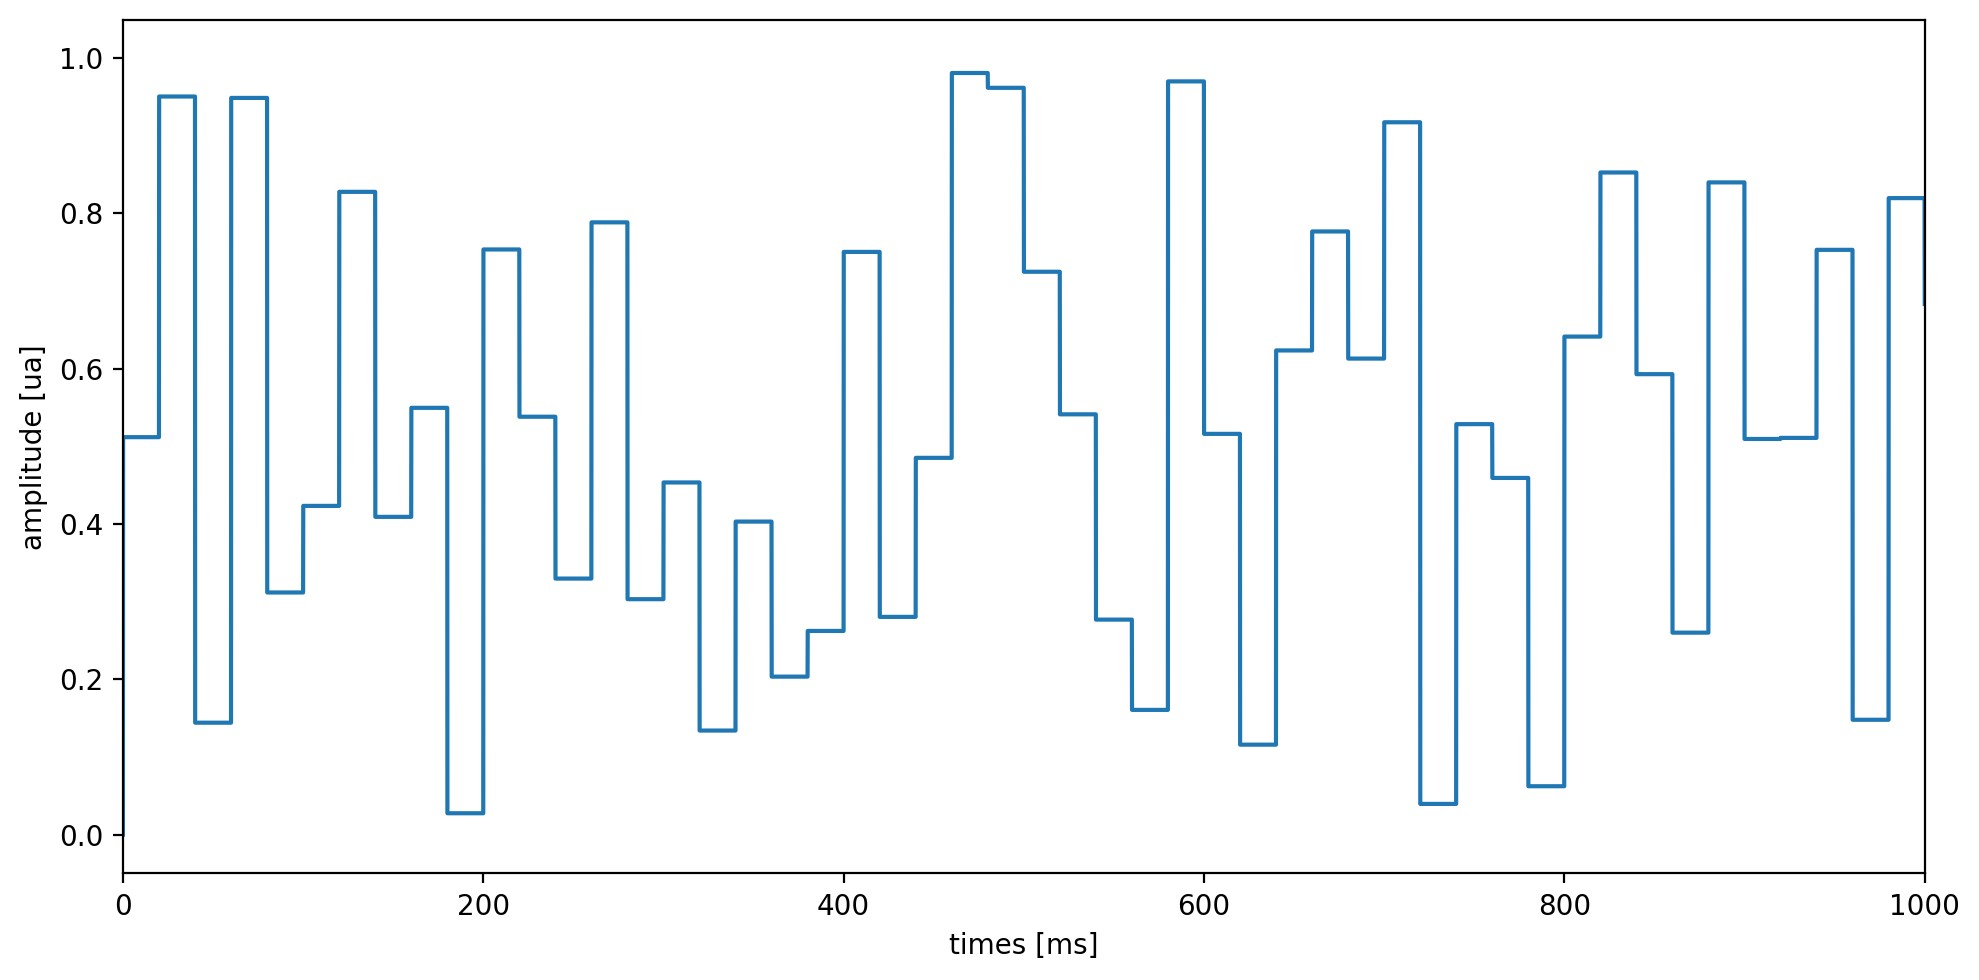

In [33]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=200
)

ax.plot(
    times,
    sig
)

ax.set_xlim(0, 1_000)
ax.set_xlabel("times [ms]")
ax.set_ylabel("amplitude [ua]")

plt.tight_layout()
plt.show()

## extract simulation results

In [34]:
# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)


Oct 23 17:40:25 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 23 17:40:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 10000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 23 17:40:44 SimulationManager::run [Info]: 
    Simulation finished.


In [35]:
# extract the simulation results
from utils.extractors import filter_spikes_parallel

sim_time = num_steps*step_duration
filter_tau = 20. # [ms]

In [36]:
def extract_results(
        enc_spks=enc_spks,
        main_spks=main_spks,
        filter_tau=filter_tau,
        sim_time=sim_time,
        nEnc=nEnc, NE=NE,
        dt=dt,
        num_threads=num_threads

):
    
    enc_activity = enc_spks.events
    enc_states = filter_spikes_parallel(
        enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
        nEnc, # total number of neuron in the encoding layer
        t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
        tau=filter_tau, 
        n_processes=num_threads
    )

    main_activity = main_spks.events
    main_states = filter_spikes_parallel(
        main_activity['times'], main_activity['senders'], 
        NE, 
        t_start=0., t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    return enc_activity, enc_states, main_activity, main_states

In [14]:
enc_activity, enc_states, main_activity, main_states = extract_results()

Filtering SpikeTrains: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]


## decoding the activity

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [17]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer: 
	- Capacity=0.4298405577912147, MSE=0.047903115757783145
Main Circuit: 
	- Capacity=0.38653964465443347, MSE=0.05331955639642214


In [39]:
from utils.capacity import compute_capacity_sequential

In [40]:
subsampling_factor = 1 # ms
max_lag = 70 # ms
step_lag = 2.0 / subsampling_factor

In [22]:
time_capacity, encoder_capacity, main_capacity = compute_capacity_sequential(
    time_vector=times,
    signal=sig[1:], 
    enc_states=enc_states,
    ex_states=main_states,
    subsampling_factor=subsampling_factor,
    max_lag=max_lag,
    step_lag=step_lag,
    dt=dt
)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.464031365413422, MSE=0.043999684479679134
Main Circuit: 
	- Capacity=0.44470667370706557, MSE=0.047370202994232787
Lag = 2.0 ms
Encoding Layer: 
	- Capacity=0.5747038461280303, MSE=0.03491741746540975
Main Circuit: 
	- Capacity=0.5499967407225856, MSE=0.03758877309417429
Lag = 4.0 ms
Encoding Layer: 
	- Capacity=0.6384906766439011, MSE=0.029684852017073236
Main Circuit: 
	- Capacity=0.6341242624056936, MSE=0.03008790223150148
Lag = 6.0 ms
Encoding Layer: 
	- Capacity=0.6753670436473526, MSE=0.0266597126137809
Main Circuit: 
	- Capacity=0.6739301331728694, MSE=0.02680713740000116
Lag = 8.0 ms
Encoding Layer: 
	- Capacity=0.7053353849704127, MSE=0.02420314516985546
Main Circuit: 
	- Capacity=0.7088399310109651, MSE=0.02411525344237449
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.7154991718149601, MSE=0.023371444128230785
Main Circuit: 
	- Capacity=0.7313747861318216, MSE=0.022413724745608654
Lag = 12.0 ms
Encoding Layer: 
	- Capacity=0.70526836

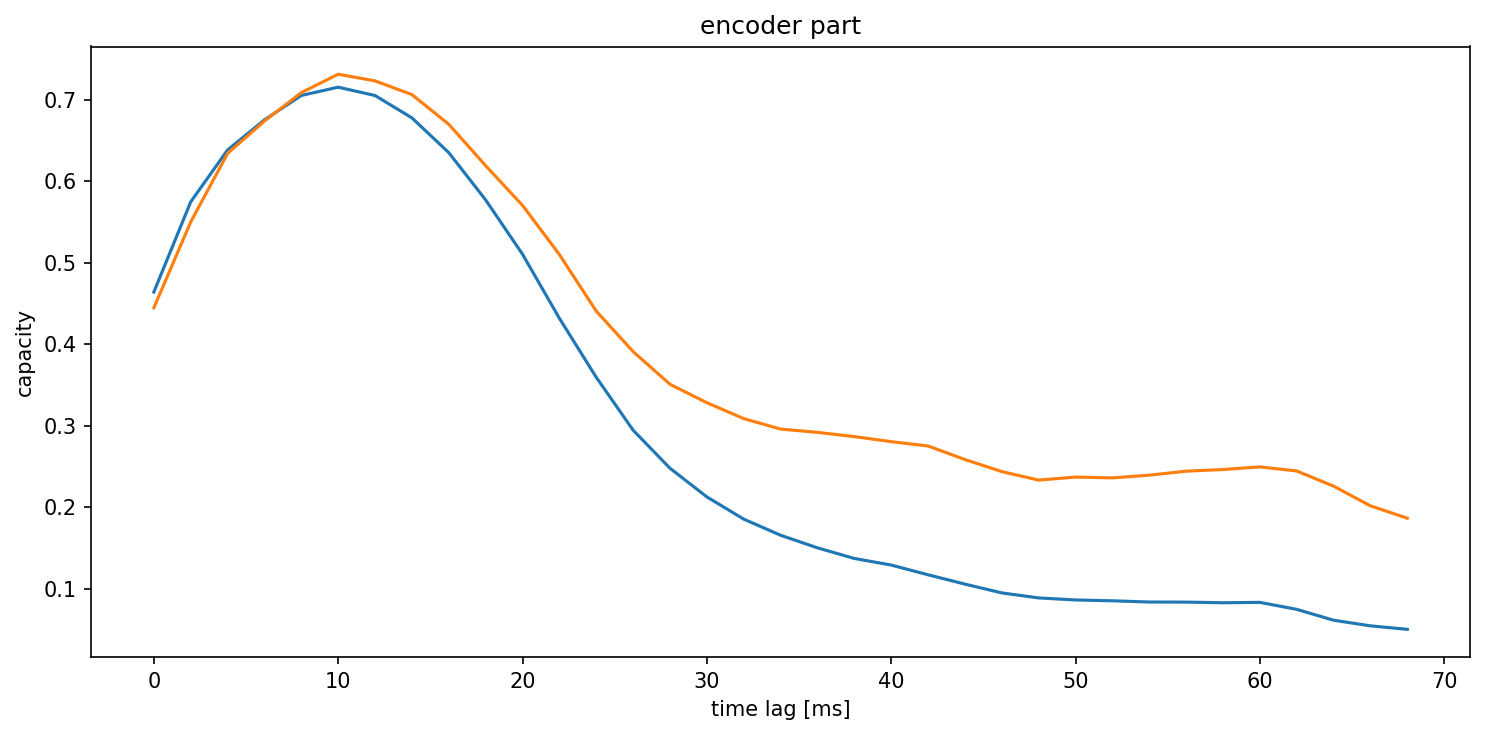

Total capacity (encoder): 20.688552625034617
Total capacity (processor): 27.676823290908533 ms


In [23]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=150,
    sharey=True
)

ax.plot(
    time_capacity,
    encoder_capacity
)
ax.plot(
    time_capacity,
    main_capacity
)
ax.set_title("encoder part")
ax.set_ylabel("capacity")
ax.set_xlabel("time lag [ms]")

plt.tight_layout()
plt.show()

print(f"Total capacity (encoder): {np.sum(encoder_capacity)*step_lag}")
print(f"Total capacity (processor): {np.sum(main_capacity)*step_lag} ms")

## run simulation

In [24]:
# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network(
    gamma=gamma,
    nEnc=nEnc,
    J_bias=J_bias,
    NE=NE, CE=CE,
    w=w, g=g, d=d
)

# generation input and connect it to the network
sig, times, inp_times, inp_amplitudes = gen_input(
    nEnc=nEnc,
    step_duration=step_duration,
    num_steps=num_steps
)

# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)

# results extraction
enc_activity, enc_states, main_activity, main_states = extract_results(
    enc_spks=enc_spks,
    main_spks=main_spks,
    filter_tau=filter_tau,
    nEnc=nEnc, NE=NE
)

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")


Oct 23 10:16:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 23 10:16:06 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 23 10:16:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 10000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 23 10:16:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [02:25<00:00,  6.88it/s]


Encoding Layer: 
	- Capacity=0.4545928111930905, MSE=0.04477407724011453
Main Circuit: 
	- Capacity=0.4505624508123811, MSE=0.04699785691398798


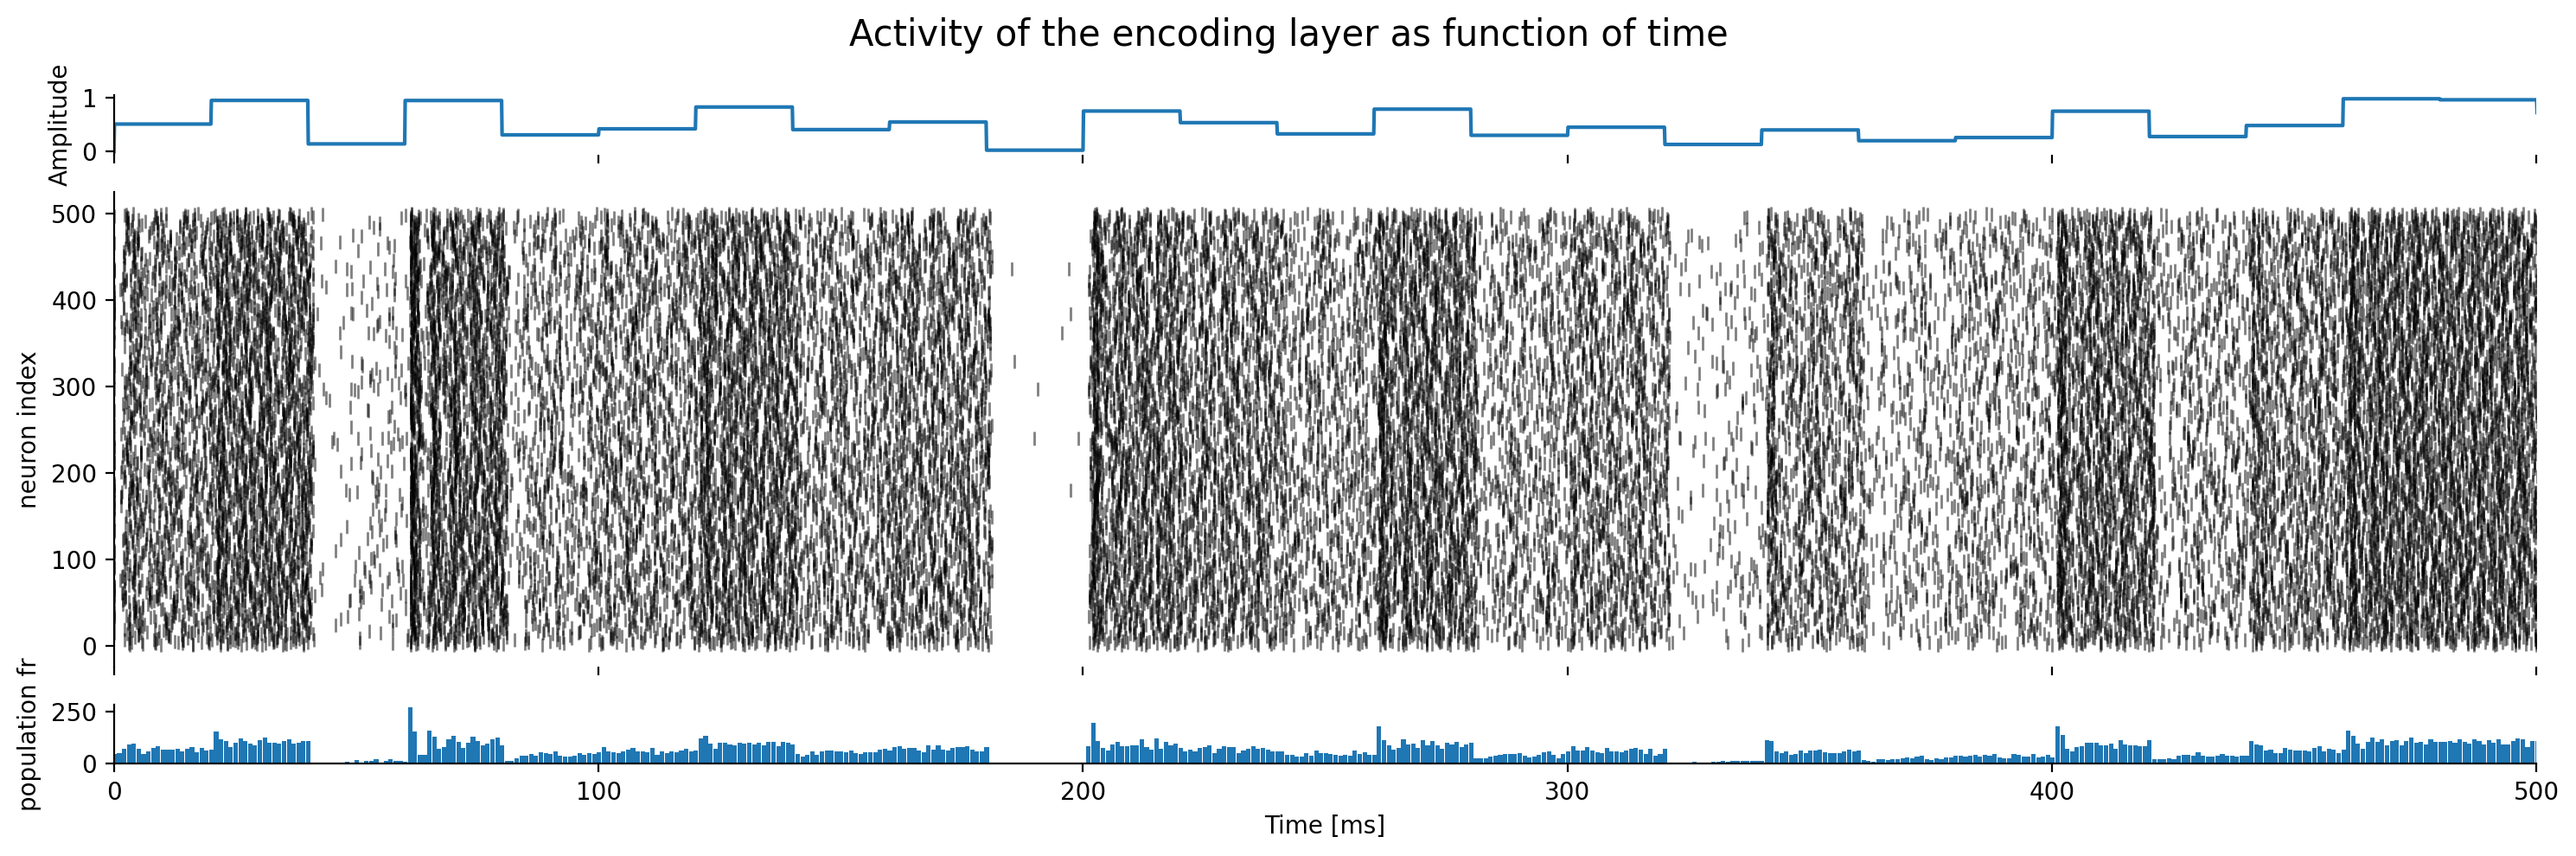

In [25]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks.events["times"],
    bins=np.linspace(
        enc_spks.events["times"].min(), 
        enc_spks.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer.pdf"), dpi=200)
plt.show()

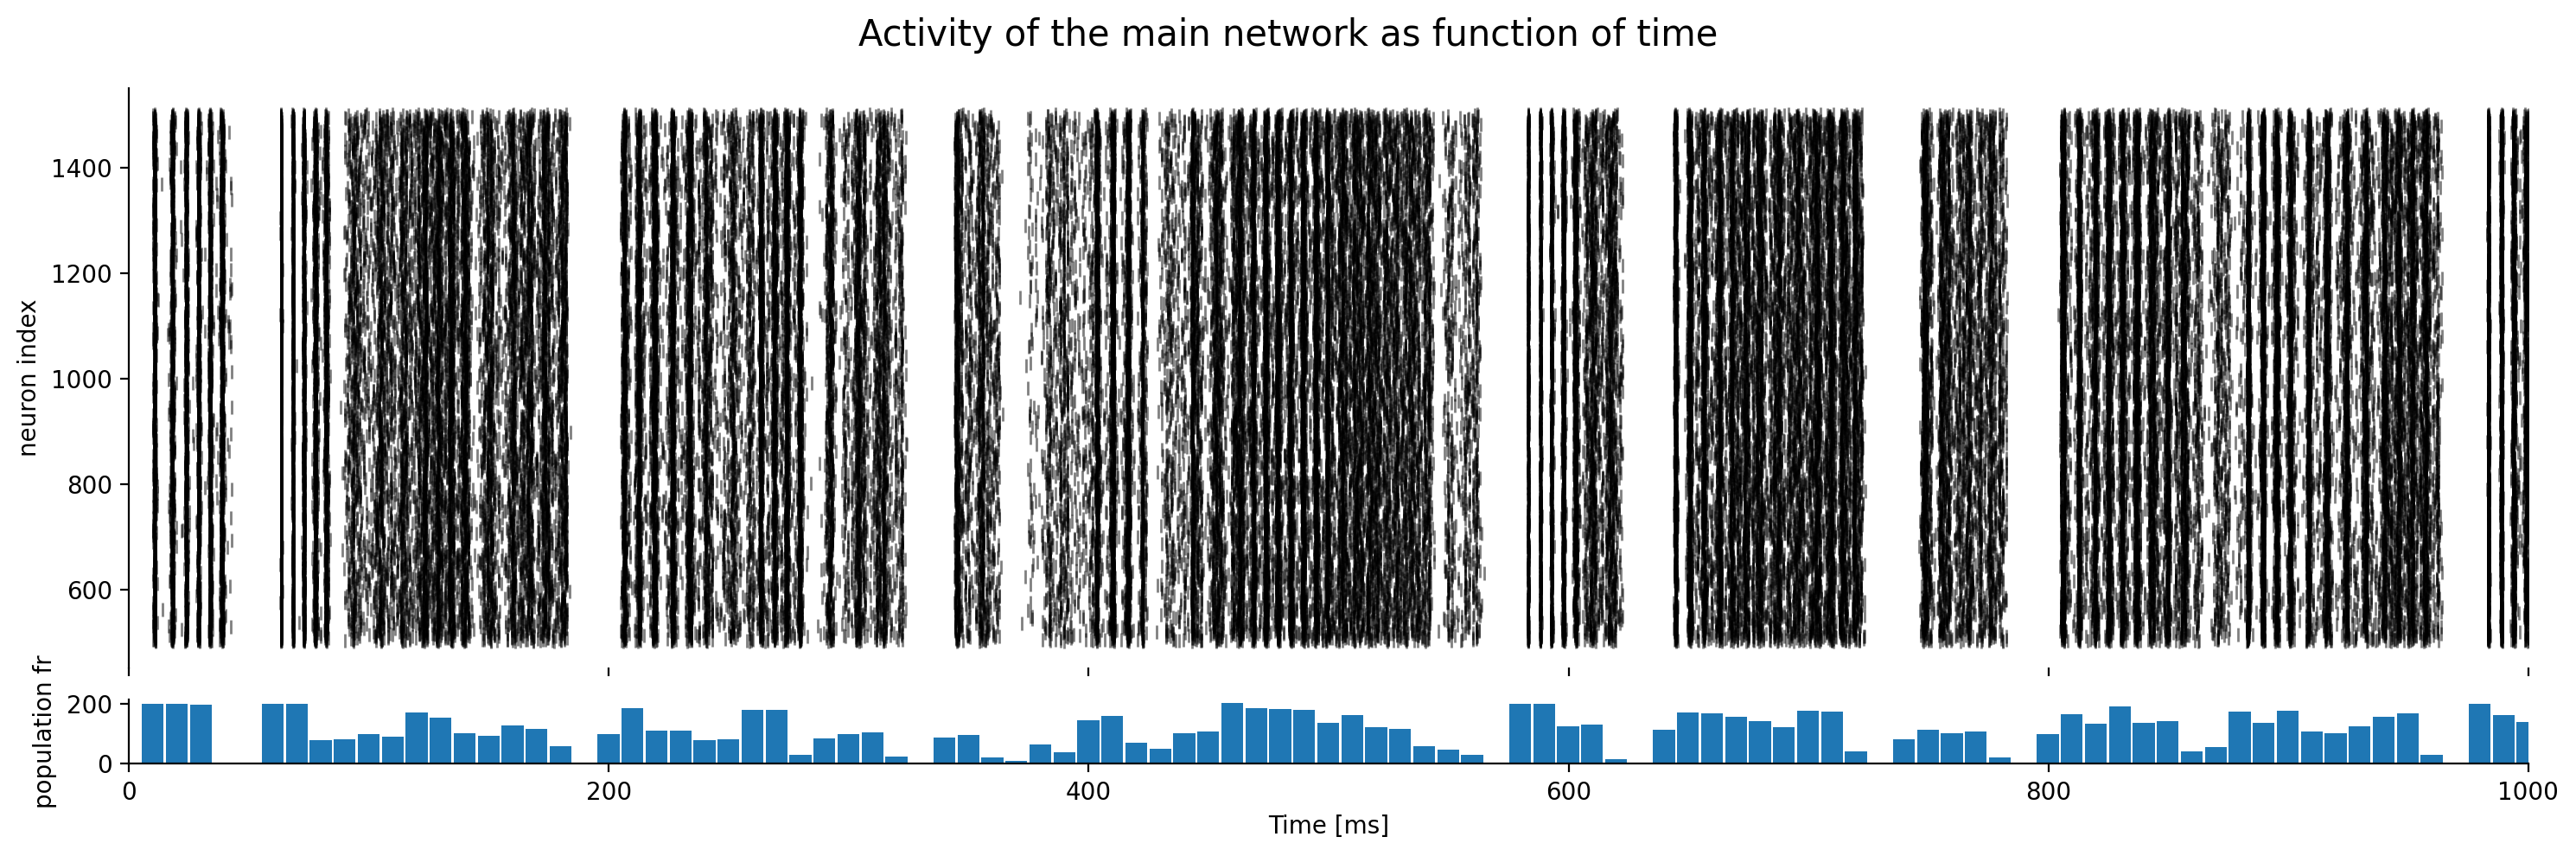

In [26]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    main_spks.events["times"],
    main_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    main_spks.events["times"],
    bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 1_000)
ax[0].set_ylabel(r"neuron index")
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr")
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the main network as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

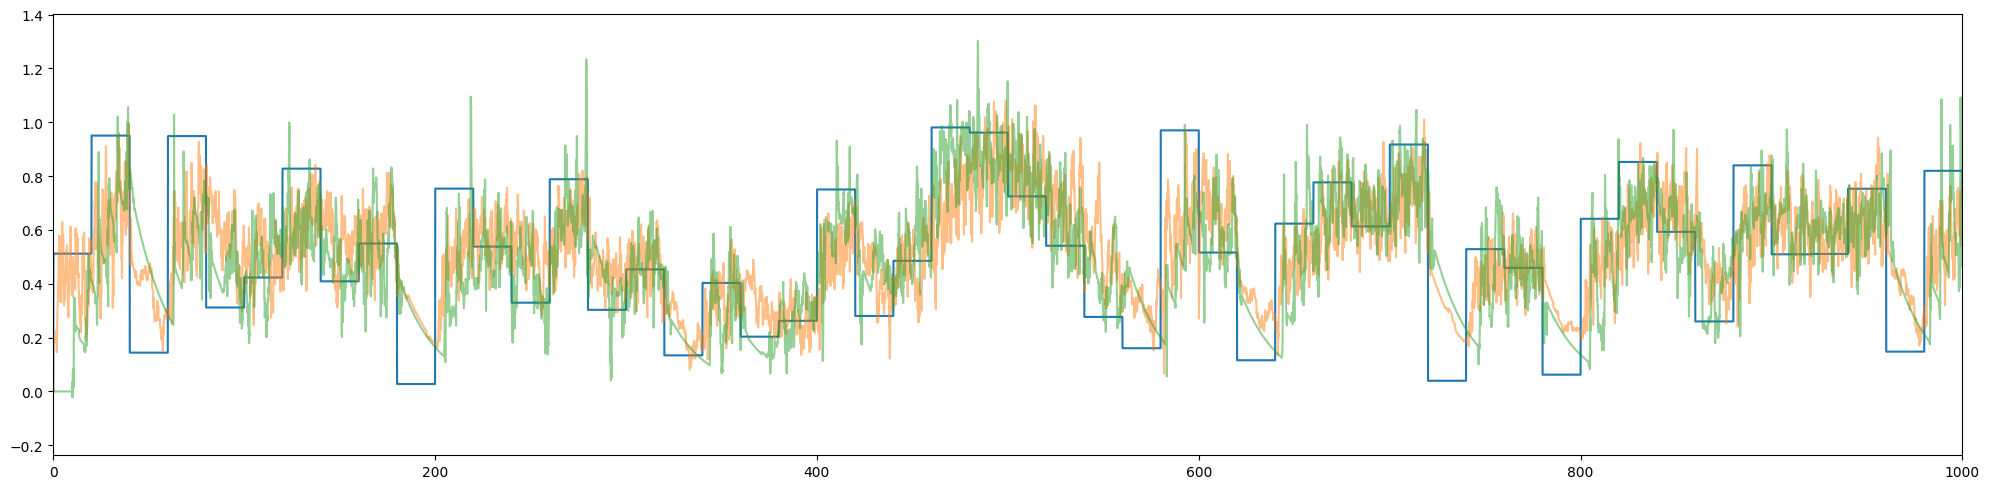

In [27]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    times,
    sig
)

ax.plot(
    times[:-1],
    enc_estimate,
    alpha=0.5   
)

ax.plot(
    times[:-1],
    main_estimate,
    alpha=0.5   
)

ax.set_xlim(0,1_000)

plt.tight_layout()
plt.show()

## influence of the step duration

In [43]:
step_duration_range = np.linspace(10, 100, 10)
num_steps = 500
step_duration_range

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [44]:
for step_dur in step_duration_range:

    if os.path.exists(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")):
        print("Already compute !")
        
    else:
        print(f"\n\n######### step duration = {step_dur} ms")
        # initialize nest kernel
        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        # generate the network
        enc_layer, enc_spks, main_spks = gen_network(
            gamma=gamma,
            nEnc=nEnc,
            J_bias=J_bias,
            NE=NE, CE=CE,
            w=w, g=g, d=d
        )

        # generation input and connect it to the network
        sig, times, inp_times, inp_amplitudes = gen_input(
            nEnc=nEnc,
            scale=scale,
            step_duration=step_dur,
            num_steps=num_steps,
        )

        # run the simulation
        sim_time = num_steps * step_dur
        nest.Simulate(sim_time)

        # results extraction
        enc_activity, enc_states, main_activity, main_states = extract_results(
            enc_spks=enc_spks,
            main_spks=main_spks,
            filter_tau=filter_tau,
            nEnc=nEnc, NE=NE,
            sim_time=sim_time
        )

        print(sig[1:].shape, enc_states.shape)
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

        print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
        print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

        np.save(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}"), main_capacity)
        np.save(os.path.join(results_fodler_name, "step_duration", f"main_estimate_stepdur_{step_dur}"), main_estimate)

Already compute !
Already compute !
Already compute !
Already compute !
Already compute !


######### step duration = 60.0 ms

Oct 23 17:41:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 23 17:41:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 23 17:41:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 30000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 23 17:42:36 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


(300000,) (500, 300000)
Encoding Layer: 
	- Capacity=0.6923780922224242, MSE=0.025253471123968516
Main Circuit: 
	- Capacity=0.6715536816106926, MSE=0.027987338164825935


######### step duration = 70.0 ms

Oct 23 17:51:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 23 17:51:10 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 23 17:51:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 35000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 23 17:52:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s]


(350000,) (500, 350000)
Encoding Layer: 
	- Capacity=0.7303672057352315, MSE=0.022134905556036703
Main Circuit: 
	- Capacity=0.701134294567357, MSE=0.025800502606177698


######### step duration = 80.0 ms

Oct 23 18:03:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 23 18:03:21 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 23 18:03:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 40000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 23 18:04:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|█████████▉| 998/1000 [07:42<00:01,  1.29it/s]

: 

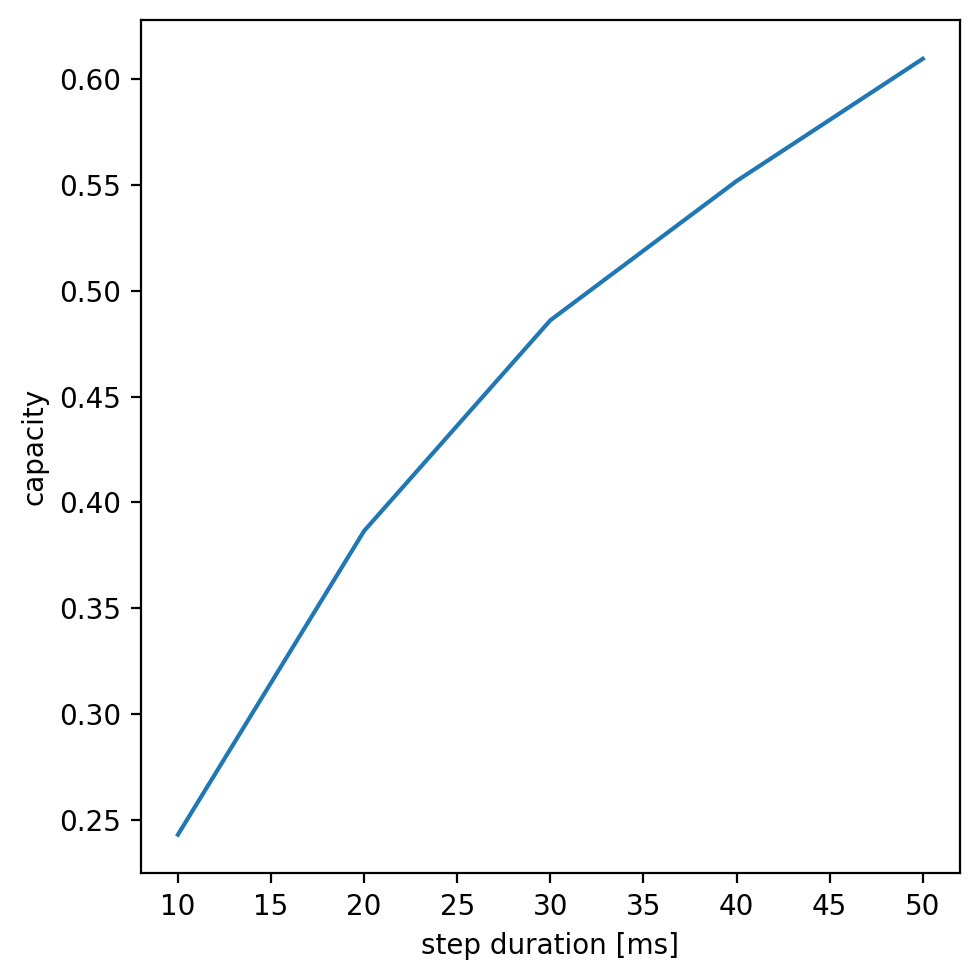

In [21]:
main_capacity = [np.load(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")).item() for step_dur in step_duration_range]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.plot(
    step_duration_range,
    main_capacity
)

ax.set_ylabel("capacity")
ax.set_xlabel("step duration [ms]")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "step_duration_influence.pdf"), dpi=200)
plt.show()


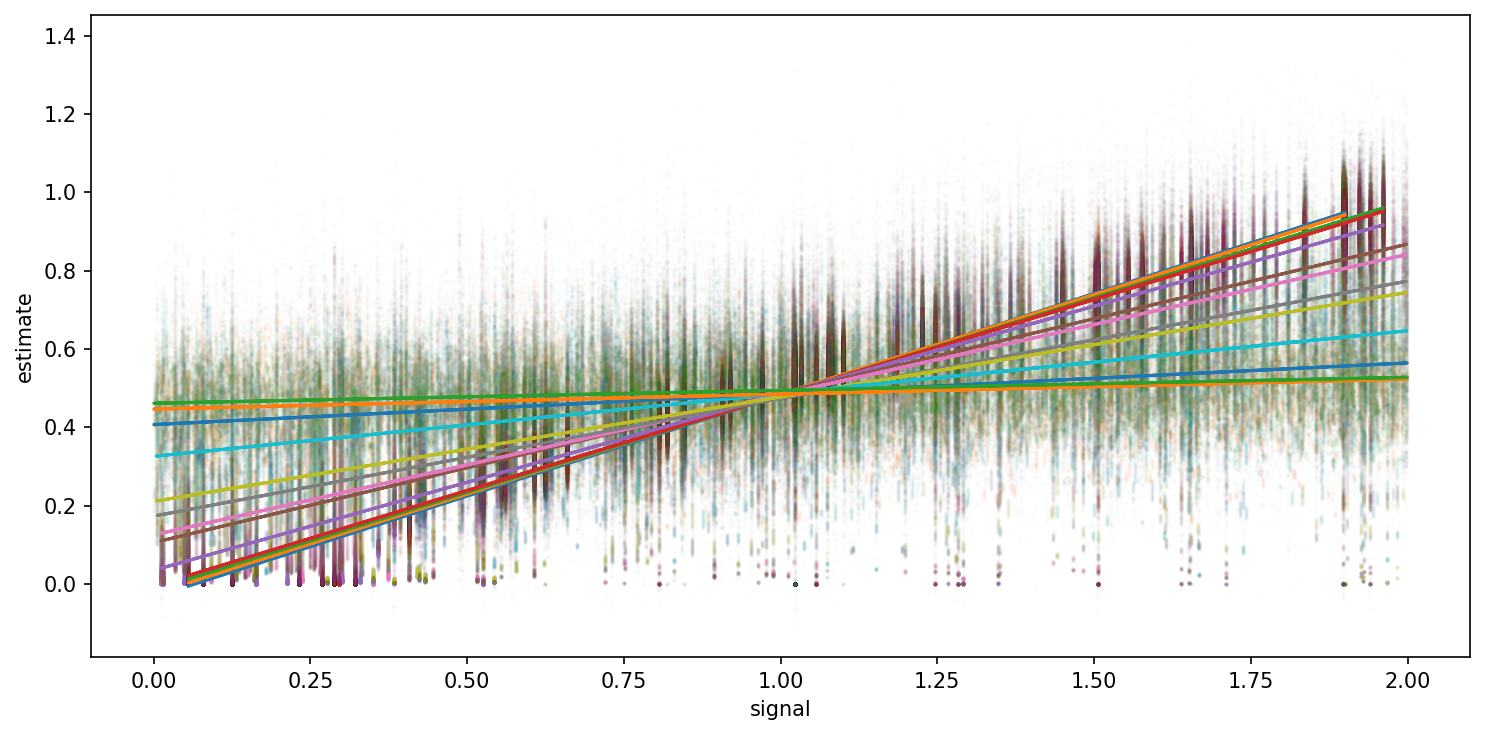

In [186]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=150
)
for step_dur in (sim_time / num_steps_range).astype(int):

    estimate = np.load(os.path.join(results_fodler_name, "step_duration", f"main_estimate_stepdur_{step_dur}.npy"))

    sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
        seed=seed, 
        num_steps=int(sim_time/step_dur),
        step_duration=step_dur, 
        resolution=dt, 
        scale=scale
        )
    
    model = LinearRegression().fit(sig[1:][:,None],estimate[:,None])
    a = model.coef_
    b = model.intercept_

    ax.scatter(
        x=sig[1:], 
        y=estimate,
        alpha=0.01,
        s=1
    )

    ax.plot(
        sig[1:], 
        (a*sig[1:]+b).T,
        label=f"step duration = {step_dur}"
    )

ax.set_xlabel("signal")
ax.set_ylabel("estimate")

plt.tight_layout()
plt.show()

## change the number of neuron in the encoding layer

In [38]:
nEnc_range = np.linspace(0, 1_000, 51, dtype=int)[1:]
print(nEnc_range)

[  20   40   60   80  100  120  140  160  180  200  220  240  260  280
  300  320  340  360  380  400  420  440  460  480  500  520  540  560
  580  600  620  640  660  680  700  720  740  760  780  800  820  840
  860  880  900  920  940  960  980 1000]


In [39]:
step_duration = 10.
num_steps = 100

In [40]:
for numEnc in nEnc_range:

    if os.path.exists(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}.npy")):
        print("Already compute !")
        
    else:
    
        sim_time = num_steps * step_duration

        # initialize nest kernel
        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        # generate the network
        enc_layer, enc_spks, main_spks = gen_network(
            gamma=gamma,
            nEnc=numEnc,
            J_bias=J_bias,
            NE=NE, CE=CE,
            w=w, g=g, d=d
        )

        # generation input and connect it to the network
        sig, times, inp_times, inp_amplitudes = gen_input(
            nEnc=numEnc,
            scale=scale,
            step_duration=step_duration,
            num_steps=num_steps,
        )

        # run the simulation
        nest.Simulate(sim_time)

        # results extraction
        enc_activity, enc_states, main_activity, main_states = extract_results(
            enc_spks=enc_spks,
            main_spks=main_spks,
            filter_tau=filter_tau,
            nEnc=numEnc, NE=NE,
            sim_time=sim_time
        )

        print(sig[1:].shape, enc_states.shape)
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

        np.save(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}"), main_error)
        np.save(os.path.join(results_fodler_name, "num_encneuron", f"main_estimate_numencneuron_{numEnc}"), main_estimate)


Oct 21 21:02:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:02:43 NodeManager::prepare_nodes [Info]: 
    Preparing 1622 nodes for simulation.

Oct 21 21:02:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1622
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:02:43 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.82it/s]


(10000,) (20, 10000)

Oct 21 21:02:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:02:51 NodeManager::prepare_nodes [Info]: 
    Preparing 1962 nodes for simulation.

Oct 21 21:02:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1962
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:02:51 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.57it/s]


(10000,) (40, 10000)

Oct 21 21:03:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:00 NodeManager::prepare_nodes [Info]: 
    Preparing 2302 nodes for simulation.

Oct 21 21:03:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2302
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:00 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 147.15it/s]


(10000,) (60, 10000)

Oct 21 21:03:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:08 NodeManager::prepare_nodes [Info]: 
    Preparing 2642 nodes for simulation.

Oct 21 21:03:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2642
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 146.59it/s]


(10000,) (80, 10000)

Oct 21 21:03:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:17 NodeManager::prepare_nodes [Info]: 
    Preparing 2982 nodes for simulation.

Oct 21 21:03:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2982
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 148.12it/s]


(10000,) (100, 10000)

Oct 21 21:03:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3322 nodes for simulation.

Oct 21 21:03:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3322
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.66it/s]


(10000,) (120, 10000)

Oct 21 21:03:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:35 NodeManager::prepare_nodes [Info]: 
    Preparing 3662 nodes for simulation.

Oct 21 21:03:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3662
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 146.50it/s]


(10000,) (140, 10000)

Oct 21 21:03:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:44 NodeManager::prepare_nodes [Info]: 
    Preparing 4002 nodes for simulation.

Oct 21 21:03:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4002
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.15it/s]


(10000,) (160, 10000)

Oct 21 21:03:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:03:54 NodeManager::prepare_nodes [Info]: 
    Preparing 4342 nodes for simulation.

Oct 21 21:03:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4342
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:03:55 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 143.86it/s]


(10000,) (180, 10000)

Oct 21 21:04:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:04 NodeManager::prepare_nodes [Info]: 
    Preparing 4682 nodes for simulation.

Oct 21 21:04:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4682
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.79it/s]


(10000,) (200, 10000)

Oct 21 21:04:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:14 NodeManager::prepare_nodes [Info]: 
    Preparing 5022 nodes for simulation.

Oct 21 21:04:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5022
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.93it/s]


(10000,) (220, 10000)

Oct 21 21:04:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:25 NodeManager::prepare_nodes [Info]: 
    Preparing 5362 nodes for simulation.

Oct 21 21:04:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5362
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.80it/s]


(10000,) (240, 10000)

Oct 21 21:04:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:35 NodeManager::prepare_nodes [Info]: 
    Preparing 5702 nodes for simulation.

Oct 21 21:04:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5702
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:36 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.44it/s]


(10000,) (260, 10000)

Oct 21 21:04:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:46 NodeManager::prepare_nodes [Info]: 
    Preparing 6042 nodes for simulation.

Oct 21 21:04:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6042
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.46it/s]


(10000,) (280, 10000)

Oct 21 21:04:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:04:57 NodeManager::prepare_nodes [Info]: 
    Preparing 6382 nodes for simulation.

Oct 21 21:04:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6382
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:04:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.25it/s]


(10000,) (300, 10000)

Oct 21 21:05:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:05:08 NodeManager::prepare_nodes [Info]: 
    Preparing 6722 nodes for simulation.

Oct 21 21:05:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6722
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:05:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.85it/s]


(10000,) (320, 10000)

Oct 21 21:05:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:05:20 NodeManager::prepare_nodes [Info]: 
    Preparing 7062 nodes for simulation.

Oct 21 21:05:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7062
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:05:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 142.77it/s]


(10000,) (340, 10000)

Oct 21 21:05:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:05:31 NodeManager::prepare_nodes [Info]: 
    Preparing 7402 nodes for simulation.

Oct 21 21:05:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7402
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:05:32 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.43it/s]


(10000,) (360, 10000)

Oct 21 21:05:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:05:43 NodeManager::prepare_nodes [Info]: 
    Preparing 7742 nodes for simulation.

Oct 21 21:05:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7742
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:05:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.38it/s]


(10000,) (380, 10000)

Oct 21 21:05:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:05:55 NodeManager::prepare_nodes [Info]: 
    Preparing 8082 nodes for simulation.

Oct 21 21:05:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8082
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:05:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.32it/s]


(10000,) (400, 10000)

Oct 21 21:06:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:06:07 NodeManager::prepare_nodes [Info]: 
    Preparing 8422 nodes for simulation.

Oct 21 21:06:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8422
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:06:08 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.88it/s]


(10000,) (420, 10000)

Oct 21 21:06:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:06:20 NodeManager::prepare_nodes [Info]: 
    Preparing 8762 nodes for simulation.

Oct 21 21:06:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8762
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:06:21 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.93it/s]


(10000,) (440, 10000)

Oct 21 21:06:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:06:32 NodeManager::prepare_nodes [Info]: 
    Preparing 9102 nodes for simulation.

Oct 21 21:06:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9102
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:06:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 146.94it/s]


(10000,) (460, 10000)

Oct 21 21:06:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:06:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9442 nodes for simulation.

Oct 21 21:06:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9442
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:06:46 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.50it/s]


(10000,) (480, 10000)

Oct 21 21:06:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:06:58 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 21:06:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:06:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.07it/s]


(10000,) (500, 10000)

Oct 21 21:07:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:07:11 NodeManager::prepare_nodes [Info]: 
    Preparing 10122 nodes for simulation.

Oct 21 21:07:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10122
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:07:13 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.62it/s]


(10000,) (520, 10000)

Oct 21 21:07:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:07:25 NodeManager::prepare_nodes [Info]: 
    Preparing 10462 nodes for simulation.

Oct 21 21:07:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10462
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:07:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.23it/s]


(10000,) (540, 10000)

Oct 21 21:07:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:07:38 NodeManager::prepare_nodes [Info]: 
    Preparing 10802 nodes for simulation.

Oct 21 21:07:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10802
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:07:40 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.18it/s]


(10000,) (560, 10000)

Oct 21 21:07:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:07:52 NodeManager::prepare_nodes [Info]: 
    Preparing 11142 nodes for simulation.

Oct 21 21:07:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11142
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:07:54 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.57it/s]


(10000,) (580, 10000)

Oct 21 21:08:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:08:07 NodeManager::prepare_nodes [Info]: 
    Preparing 11482 nodes for simulation.

Oct 21 21:08:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11482
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:08:08 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 142.84it/s]


(10000,) (600, 10000)

Oct 21 21:08:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:08:21 NodeManager::prepare_nodes [Info]: 
    Preparing 11822 nodes for simulation.

Oct 21 21:08:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11822
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:08:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.08it/s]


(10000,) (620, 10000)

Oct 21 21:08:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:08:36 NodeManager::prepare_nodes [Info]: 
    Preparing 12162 nodes for simulation.

Oct 21 21:08:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12162
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:08:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.25it/s]


(10000,) (640, 10000)

Oct 21 21:08:50 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:08:50 NodeManager::prepare_nodes [Info]: 
    Preparing 12502 nodes for simulation.

Oct 21 21:08:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12502
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:08:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 142.95it/s]


(10000,) (660, 10000)

Oct 21 21:09:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:09:05 NodeManager::prepare_nodes [Info]: 
    Preparing 12842 nodes for simulation.

Oct 21 21:09:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12842
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:09:07 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.68it/s]


(10000,) (680, 10000)

Oct 21 21:09:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:09:21 NodeManager::prepare_nodes [Info]: 
    Preparing 13182 nodes for simulation.

Oct 21 21:09:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13182
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:09:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.85it/s]


(10000,) (700, 10000)

Oct 21 21:09:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:09:36 NodeManager::prepare_nodes [Info]: 
    Preparing 13522 nodes for simulation.

Oct 21 21:09:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13522
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:09:38 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.02it/s]


(10000,) (720, 10000)

Oct 21 21:09:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:09:51 NodeManager::prepare_nodes [Info]: 
    Preparing 13862 nodes for simulation.

Oct 21 21:09:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13862
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:09:53 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 142.25it/s]


(10000,) (740, 10000)

Oct 21 21:10:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:10:07 NodeManager::prepare_nodes [Info]: 
    Preparing 14202 nodes for simulation.

Oct 21 21:10:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14202
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:10:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.44it/s]


(10000,) (760, 10000)

Oct 21 21:10:23 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:10:23 NodeManager::prepare_nodes [Info]: 
    Preparing 14542 nodes for simulation.

Oct 21 21:10:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14542
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:10:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.72it/s]


(10000,) (780, 10000)

Oct 21 21:10:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:10:40 NodeManager::prepare_nodes [Info]: 
    Preparing 14882 nodes for simulation.

Oct 21 21:10:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14882
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:10:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 142.71it/s]


(10000,) (800, 10000)

Oct 21 21:10:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:10:56 NodeManager::prepare_nodes [Info]: 
    Preparing 15222 nodes for simulation.

Oct 21 21:10:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15222
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:10:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.69it/s]


(10000,) (820, 10000)

Oct 21 21:11:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:11:13 NodeManager::prepare_nodes [Info]: 
    Preparing 15562 nodes for simulation.

Oct 21 21:11:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15562
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:11:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 143.88it/s]


(10000,) (840, 10000)

Oct 21 21:11:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:11:30 NodeManager::prepare_nodes [Info]: 
    Preparing 15902 nodes for simulation.

Oct 21 21:11:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15902
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:11:32 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 142.40it/s]


(10000,) (860, 10000)

Oct 21 21:11:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:11:47 NodeManager::prepare_nodes [Info]: 
    Preparing 16242 nodes for simulation.

Oct 21 21:11:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16242
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:11:49 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 143.53it/s]


(10000,) (880, 10000)

Oct 21 21:12:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:12:04 NodeManager::prepare_nodes [Info]: 
    Preparing 16582 nodes for simulation.

Oct 21 21:12:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16582
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:12:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:08<00:00, 122.22it/s]


(10000,) (900, 10000)

Oct 21 21:12:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:12:23 NodeManager::prepare_nodes [Info]: 
    Preparing 16922 nodes for simulation.

Oct 21 21:12:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16922
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:12:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 143.80it/s]


(10000,) (920, 10000)

Oct 21 21:12:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:12:41 NodeManager::prepare_nodes [Info]: 
    Preparing 17262 nodes for simulation.

Oct 21 21:12:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17262
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:12:43 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 144.56it/s]


(10000,) (940, 10000)

Oct 21 21:12:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:12:59 NodeManager::prepare_nodes [Info]: 
    Preparing 17602 nodes for simulation.

Oct 21 21:12:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17602
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:13:01 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 145.59it/s]


(10000,) (960, 10000)

Oct 21 21:13:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:13:17 NodeManager::prepare_nodes [Info]: 
    Preparing 17942 nodes for simulation.

Oct 21 21:13:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17942
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:13:19 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 142.86it/s]


(10000,) (980, 10000)

Oct 21 21:13:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 21:13:35 NodeManager::prepare_nodes [Info]: 
    Preparing 18282 nodes for simulation.

Oct 21 21:13:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 18282
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 21:13:38 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 143.27it/s]


(10000,) (1000, 10000)


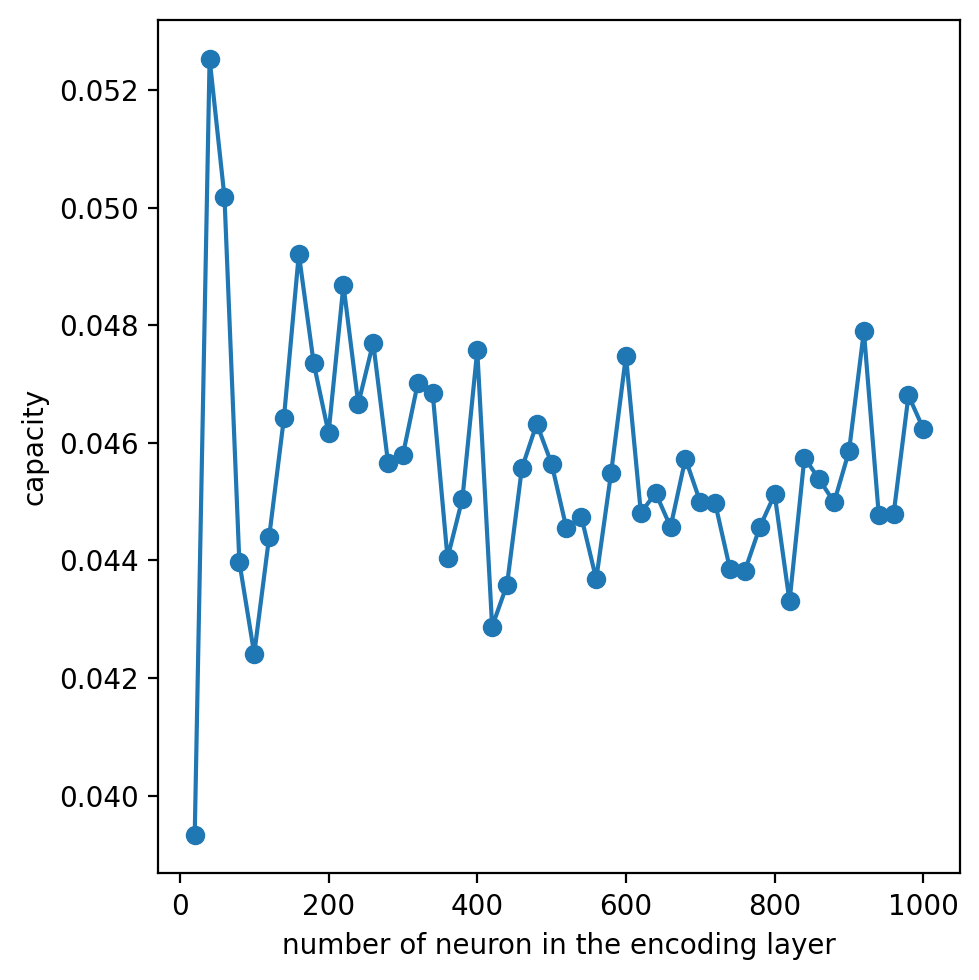

In [41]:
main_capacity = [np.load(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}.npy")).item() for numEnc in nEnc_range]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.plot(
    nEnc_range,
    main_capacity,
    marker="o"
)

ax.set_ylabel("capacity")
ax.set_xlabel("number of neuron in the encoding layer")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "encoding_neuron_number__influence.pdf"), dpi=200)
plt.show()
